In [1]:
import pandas as pd
import numpy as np

import data_pull as dp
import geopandas as gpd

building_df: pd.DataFrame = dp.get_building_data()
citibike_df: pd.DataFrame = dp.get_citibike_data()
nta_demo_df: pd.DataFrame = dp.get_nta_demographics()
nta_geodf: gpd.GeoDataFrame = dp.get_nta_geog() # we have our geopandas multipolygon in the column called "geometry"
nta_geodf = nta_geodf[nta_geodf['BoroName'] != 'Staten Island']



/Users/alexfriedman/Downloads/lrFinalProject/venv/lib/python3.10/site-packages/openpyxl/reader/workbook.py:118: UserWarning: Print area cannot be set to Defined name: #N/A.
  warn(f"Print area cannot be set to Defined name: {defn.value}.")


In [22]:
unique_start_stations = citibike_df.groupby(['start_station_id','start_lat', 'start_lng']).first()
unique_start_stations = unique_start_stations.reset_index()
unique_end_stations = citibike_df.groupby(['end_station_id','end_lat', 'end_lng']).first()
unique_end_stations = unique_end_stations.reset_index()
unique_stations = pd.concat([unique_start_stations, unique_end_stations], axis=0)
unique_stations.drop_duplicates(subset=['start_station_id', 'start_lat', 'start_lng'], inplace=True)
unique_stations = unique_stations[['start_station_id', 'start_lat', 'start_lng']].dropna()
unique_stations.columns = ['station_id', 'lat', 'lng']

## Notes:

- We need to map CitiBike Stations to NTA 2010
- We need to map Buildings to NTA 2010
- We need to map CitiBike Stations to Buildings





In [62]:
from shapely.geometry import Point
unique_stations.crs = "EPSG:4326"  # WGS 84, commonly used for lat/long coordinates
geometry = [Point(lon, lat) for lon, lat in zip(unique_stations['lng'], unique_stations['lat'])]
unique_stations_gdf = gpd.GeoDataFrame(unique_stations, geometry=geometry, crs='EPSG:4326')
unique_stations_gdf = gpd.sjoin(unique_stations_gdf, nta_geodf, how='left', op='within')
unique_stations_gdf

/Users/alexfriedman/Downloads/lrFinalProject/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


,station_id,lat,lng,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area
0,72,40.767272,-73.993929,POINT (-73.99393 40.76727),139.0,1.0,Manhattan,61.0,MN15,Clinton,34570.938945,1.837385e+07
1,79,40.719116,-74.006667,POINT (-74.00667 40.71912),144.0,1.0,Manhattan,61.0,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26855.031513,2.503268e+07
2,82,40.711174,-74.000165,POINT (-74.00017 40.71117),85.0,1.0,Manhattan,61.0,MN27,Chinatown,20786.254613,1.450188e+07
3,83,40.683826,-73.976323,POINT (-73.97632 40.68383),6.0,3.0,Brooklyn,47.0,BK68,Fort Greene,19825.520859,1.648282e+07
4,116,40.741776,-74.001497,POINT (-74.00150 40.74178),138.0,1.0,Manhattan,61.0,MN13,Hudson Yards-Chelsea-Flatiron-Union Square,45412.960917,3.705437e+07
...,...,...,...,...,...,...,...,...,...,...,...,...
6897,SYS033,40.728487,-74.011693,POINT (-74.01169 40.72849),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07
6898,SYS035,40.728660,-74.011980,POINT (-74.01198 40.72866),179.0,1.0,Manhattan,61.0,MN23,West Village,27119.922778,2.488638e+07
6899,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08
6900,SYS052,40.604017,-74.019709,POINT (-74.01971 40.60402),194.0,3.0,Brooklyn,47.0,BK99,park-cemetery-etc-Brooklyn,385416.939727,2.253711e+08


In [44]:
building_df.crs = "EPSG:4326"
geometry = [Point(lon, lat) for lon, lat in zip(building_df['longitude'], building_df['latitude'])]
buildings_gdf = gpd.GeoDataFrame(building_df, geometry = geometry, crs='EPSG:4326')

buildings_gdf_nta = gpd.sjoin(buildings_gdf, nta_geodf, how='left', op='within')


/Users/alexfriedman/Downloads/lrFinalProject/venv/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3488: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


property_id               object
latitude                  object
longitude                 object
borough                   object
primary_property_type     object
                          ...   
CountyFIPS                 int64
NTACode                   object
NTAName                   object
Shape_Leng               float64
Shape_Area               float64
Length: 80, dtype: object

In [48]:
import numpy as np

cat_cols = [
    'primary_property_type',
    '_2nd_largest_property_use',
    '_3rd_largest_property_use',
    'metered_areas_energy',
    'metered_areas_water',
    #'national_median_reference',
    'borough',
    #'nta',
    'estimated_data_flag',
    'estimated_data_flag_natural',
    'estimated_data_flag_fuel',
    'estimated_data_flag_fuel_1',
    'estimated_data_flag_fuel_2',
    'estimated_data_flag_fuel_3',
    'estimated_data_flag_district',
    #'estimated_data_flag_1',
    'estimated_values_energy',
    'estimated_values_water',
    'alert_data_center_issue_with',
    'alert_energy_meter_has_less',
    'alert_energy_meter_has_gaps',
    'alert_energy_meter_has',
    'alert_energy_no_meters',
    'alert_energy_meter_has_single',
    'alert_water_meter_has_less',
    'alert_property_has_no_uses'
]

num_cols = [
    'largest_property_use_type_1',
    'year_built',
    'number_of_buildings',
    'occupancy',
    #'_3rd_largest_property_use_1',
    'property_gfa_calculated_1',

    "energy_star_score",

    'site_eui_kbtu_ft',
    'weather_normalized_site_eui',
    #'national_median_site_eui',
    'site_energy_use_kbtu',
    'weather_normalized_site_energy',
    'weather_normalized_site',
    #'weather_normalized_site_1',
    'source_eui_kbtu_ft',
    'weather_normalized_source',
    'national_median_source_eui',
    'source_energy_use_kbtu',
    #'weather_normalized_source_1',
    'fuel_oil_1_use_kbtu',
    #'fuel_oil_2_use_kbtu',
    #'fuel_oil_4_use_kbtu',
    #'fuel_oil_5_6_use_kbtu',
    #'diesel_2_use_kbtu',
    'propane_use_kbtu',
    'district_steam_use_kbtu',
    'district_hot_water_use_kbtu',
    'district_chilled_water_use',
    'natural_gas_use_kbtu',
    'natural_gas_use_therms',
    #'weather_normalized_site_2',
    'electricity_use_grid_purchase',
    'electricity_use_grid_purchase_1',
    #'weather_normalized_site_3',
    #'electricity_use_grid_purchase_2',
    #'electricity_use_grid_purchase_3',
    'electricity_use_generated',
    'electricity_use_generated_1',
    #'electricity_use_generated_2',
    #'electricity_use_generated_3',
    'green_power_onsite_kwh',
    'green_power_offsite_kwh',
    'green_power_onsite_and_offsite',
    #'total_ghg_emissions_metric',
    #'direct_ghg_emissions_metric',
    'total_ghg_emissions_intensity',
    #'direct_ghg_emissions_intensity',
    #'indirect_ghg_emissions_metric',
    #'net_emissions_metric_tons',
    #'indirect_ghg_emissions',
    #'national_median_total_ghg',
    'egrid_output_emissions_rate',
    'avoided_emissions_onsite',
    'avoided_emissions_offsite',
    #'avoided_emissions_onsite_1',
    'percent_of_electricity_that',
    'percent_of_recs_retained',
    'percent_of_total_electricity',
    'water_use_all_water_sources',
    'municipally_supplied_potable',
    #'municipally_supplied_potable_1',
    #'municipally_supplied_potable_2',
    #'municipally_supplied_potable_3'
]

other_cols = [
    'reason_s_for_no_score',
    'energy_star_certification',
    'energy_star_certification_1',
    'annual_maximum_demand_kw',
    'annual_maximum_demand_mm',
    'annual_maximum_demand_meter',
]

date_cols = [
    'last_modified_date_property',
    'last_modified_date_electric',
    'last_modified_date_gas_meters',
    'last_modified_date_non',
    'last_modified_date_water',
    'last_modified_date_property_1'
]

cat_cols = list(set(cat_cols).intersection(buildings_gdf_nta.columns))
num_cols = list(set(num_cols).intersection(buildings_gdf_nta.columns))
other_cols = list(set(other_cols).intersection(buildings_gdf_nta.columns))
date_cols = list(set(date_cols).intersection(buildings_gdf_nta.columns))
for _col in num_cols:
    try:
        buildings_gdf_nta[_col] = buildings_gdf_nta[_col].astype(np.float64)
    except:
        print(_col)
        


electricity_use_grid_purchase_1
electricity_use_grid_purchase
natural_gas_use_therms
natural_gas_use_kbtu


In [36]:
hh_income = [
"HHIU10P",
"HHI10t14P",
"HHI15t24P",
"HHI25t34P",
"HHI35t49P",
"HHI50t74P",
"HHI75t99P",
"HI100t149P",
"HI150t199P",
"HHI200plP",
"MdHHIncP",
"MnHHIncP",
"Inc_SoSecP",
"Inc_RtrmtP",
"Inc_SpSecP",
"Inc_CPbAP",
"Inc_SNAPP"
]

In [37]:
income_to_poverty = [
    'PopPvU2P',
    'PvU50P',
    'Pv50t74P',
    'Pv75t99P',
    'Pv100t124P',
    'Pv125t149P',
    'Pv150t174P',
    'Pv175t184P',
    'Pv185t199P',
    'Pv200t299P',
    "Pv300t399P",
    "Pv400t499P",
    'Pv500plP'
    ]



,HHIU10P,HHI10t14P,HHI15t24P,HHI25t34P,HHI35t49P,HHI50t74P,HHI75t99P,HI100t149P,HI150t199P,HHI200plP,MdHHIncP,MnHHIncP,Inc_SoSecP,Inc_RtrmtP,Inc_SpSecP,Inc_CPbAP,Inc_SNAPP
7,4.0,3.5,5.2,5.0,6.6,8.7,10.8,18.1,11.9,26.2,NaN,NaN,21.3,10.9,2.5,0.4,3.0
43,9.5,7.0,10.3,9.9,10.8,15.3,11.7,14.9,5.4,5.2,NaN,NaN,29.8,16.9,8.6,2.7,18.5
6,19.7,10.0,10.8,9.0,9.9,15.2,7.1,8.7,4.9,4.7,NaN,NaN,24.8,11.3,19.9,3.7,34.1
42,21.8,12.1,15.1,9.6,10.0,12.6,6.5,7.2,2.6,2.5,NaN,NaN,28.7,10.1,29.8,6.8,51.5
48,14.2,10.6,12.5,6.6,13.2,15.7,11.0,10.4,4.0,1.9,NaN,NaN,42.9,14.4,20.0,3.0,28.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,11.3,4.9,12.8,9.6,9.8,13.9,13.3,14.3,6.2,4.1,NaN,NaN,27.4,14.3,8.3,7.3,26.9
146,5.2,5.1,7.3,7.1,9.9,14.0,14.1,18.9,11.7,6.8,NaN,NaN,35.1,22.8,4.8,3.1,10.5
139,4.6,2.5,4.5,5.5,9.8,18.4,12.4,24.0,10.5,7.8,NaN,NaN,34.5,19.3,2.6,1.0,4.1
142,3.2,3.3,5.8,6.2,7.2,14.5,15.1,24.5,12.8,7.3,NaN,NaN,35.1,24.0,4.0,1.6,5.0


In [77]:
buildings_gdf_nta

,property_id,latitude,longitude,borough,primary_property_type,largest_property_use_type,largest_property_use_type_1,year_built,construction_status,number_of_buildings,...,water_use_all_water_sources,geometry,index_right,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area
0,21205224,40.769272,-73.913633,QUEENS,Multifamily Housing,Multifamily Housing,25000.0,2010.0,Existing,1.0,...,910.8,POINT (-73.91363 40.76927),122,4,Queens,81,QN70,Astoria,32536.016498,3.933504e+07
1,2665352,40.790503,-73.96792,MANHATTAN,Multifamily Housing,Multifamily Housing,260780.0,1970.0,Existing,1.0,...,12826.8,POINT (-73.96792 40.79050),120,1,Manhattan,61,MN12,Upper West Side,29160.206508,3.437994e+07
2,2665400,40.792758,-73.965171,MANHATTAN,Multifamily Housing,Multifamily Housing,324378.0,1943.0,Existing,1.0,...,16038.0,POINT (-73.96517 40.79276),120,1,Manhattan,61,MN12,Upper West Side,29160.206508,3.437994e+07
7,2665443,40.837333,-73.94006,MANHATTAN,Multifamily Housing,Multifamily Housing,52428.0,1958.0,Existing,1.0,...,4819.8,POINT (-73.94006 40.83733),83,1,Manhattan,61,MN36,Washington Heights South,22143.342097,2.312709e+07
8,2665447,40.837275,-73.94423,MANHATTAN,Multifamily Housing,Multifamily Housing,70384.0,1973.0,Existing,1.0,...,7408.1,POINT (-73.94423 40.83727),83,1,Manhattan,61,MN36,Washington Heights South,22143.342097,2.312709e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28994,6575086,40.656592,-73.958524,BROOKLYN,Multifamily Housing,Multifamily Housing,38199.0,1931.0,Existing,1.0,...,2663.5,POINT (-73.95852 40.65659),167,3,Brooklyn,47,BK60,Prospect Lefferts Gardens-Wingate,29561.659001,3.163843e+07
28995,6575119,40.632396,-73.945691,BROOKLYN,Multifamily Housing,Multifamily Housing,38736.0,1927.0,Existing,1.0,...,3383.1,POINT (-73.94569 40.63240),130,3,Brooklyn,47,BK42,Flatbush,38738.408722,4.524620e+07
28996,6575799,40.66785,-73.958034,BROOKLYN,Multifamily Housing,Multifamily Housing,35824.0,1924.0,Existing,1.0,...,2022.0,POINT (-73.95803 40.66785),46,3,Brooklyn,47,BK63,Crown Heights South,24180.831751,1.597907e+07
28998,12060686,40.659816,-73.866717,BROOKLYN,Distribution Center,Distribution Center,280000.0,2014.0,Existing,1.0,...,303.0,POINT (-73.86672 40.65982),189,3,Brooklyn,47,BK82,East New York,87935.225330,1.170302e+08


In [76]:
buildings_gdf_nta.groupby('NTACode').agg({
    # 'energy_star_score': 'mean',
    'site_eui_kbtu_ft': 'mean',
    # 'source_eui_kbtu_ft': 'mean',
    # 'primary_property_type': 'mode'
    'occupancy': 'mean',
    'green_power_onsite_and_offsite': 'mean',
    'total_ghg_emissions_intensity': 'mean',
})

AttributeError: 'SeriesGroupBy' object has no attribute 'mode'

In [78]:
nta_energy_score_df = buildings_gdf_nta[['site_eui_kbtu_ft']].groupby('NTACode')[['site_eui_kbtu_ft']].mean().reset_index()
nta_energy_score_df

KeyError: 'NTACode'

<Axes: >

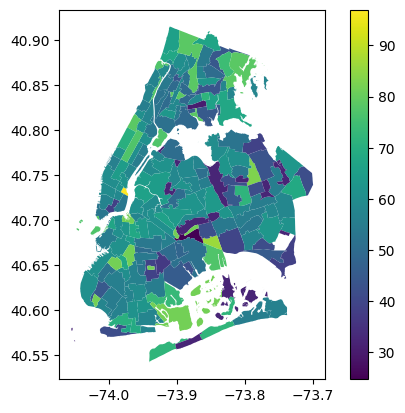

In [58]:
nta_energy_gdf = nta_geodf.merge(nta_energy_score_df, on='NTACode', how='left')
nta_energy_gdf[nta_energy_gdf['BoroName'] != 'Staten Island'].plot(column='energy_star_score', legend=True)

<Axes: >

<Figure size 1200x1200 with 0 Axes>

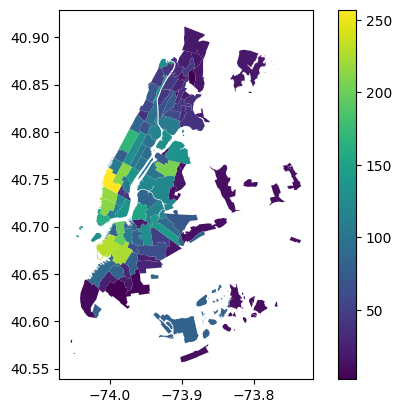

In [72]:
import matplotlib.pyplot as plt

# n rides start in nta
# n rides that end in nta
# n rides that start and end in nta
# avg length of ride
# most popular rideable type
# avg distance between start and end 


nta_stations_count = unique_stations_gdf.groupby('NTACode').size().reset_index()
plt.figure(figsize=(12, 12))
stations_by_nta_gdf = nta_geodf.merge(nta_stations_count, on='NTACode', how='left')
stations_by_nta_gdf.plot(column=0, legend=True)

In [66]:
stations_by_nta_gdf

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry,0
0,4,Queens,81,QN08,St. Albans,45401.316803,7.741275e+07,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",NaN
1,2,Bronx,5,BX28,Van Cortlandt Village,21945.719299,2.566612e+07,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ...",23.0
2,4,Queens,81,QN55,South Ozone Park,36708.169305,8.246139e+07,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ...",NaN
3,3,Brooklyn,47,BK50,Canarsie,43703.609666,8.208968e+07,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",NaN
4,2,Bronx,5,BX41,Mount Hope,18937.247819,1.471671e+07,"MULTIPOLYGON (((-73.89561 40.85457, -73.89662 ...",28.0
...,...,...,...,...,...,...,...,...,...
190,3,Brooklyn,47,BK93,Starrett City,17414.782656,1.159895e+07,"MULTIPOLYGON (((-73.88829 40.64672, -73.88829 ...",NaN
191,3,Brooklyn,47,BK73,North Side-South Side,28099.984508,2.885436e+07,"MULTIPOLYGON (((-73.95814 40.72440, -73.95772 ...",152.0
192,1,Manhattan,61,MN28,Lower East Side,26879.113421,2.330069e+07,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",134.0
193,3,Brooklyn,47,BK40,Windsor Terrace,19033.671554,1.404167e+07,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ...",30.0


In [83]:
unique_stations

,station_id,lat,lng
0,72,40.767272,-73.993929
1,79,40.719116,-74.006667
2,82,40.711174,-74.000165
3,83,40.683826,-73.976323
4,116,40.741776,-74.001497
...,...,...,...
6897,SYS033,40.728487,-74.011693
6898,SYS035,40.728660,-74.011980
6899,SYS052,40.604017,-74.019709
6900,SYS052,40.604017,-74.019709


In [84]:
import googlemaps

gmaps = googlemaps.Client(key='INSERT KEY HERE')


In [128]:
def to_feet(meters):
    return meters * 3.28084

def get_directions(start_coords: tuple[float, float], end_coords: tuple[float, float]) -> dict[str, float]:
    """
    
    :param start_coords: starting coordinates (lat, lng)
    :param end_coords: ending coordinates (lat, lng)
    :return: dictionary of:
        - duration: time in seconds
        - distance: distance in feet
        - elevation: elevation change in feet
    """
    start_lat, start_lng = start_coords
    end_lat, end_lng = end_coords
    dirs = gmaps.directions((start_lat, start_lng), (end_lat, end_lng), mode='bicycling')
    return parse_directions(dirs)
    
    
def parse_directions(directions):
    steps, n_samples = get_steps(directions)
    duration = directions[0]['legs'][0]['duration']['value']
    distance = directions[0]['legs'][0]['distance']['value']
    elevation = get_elevation(steps, n_samples)
    return {
        'duration': duration,
        'distance': round(to_feet(distance), 2),
        'elevation': elevation
    }
    
    
def get_steps(directions):
    steps = []
    n_samples = 0
    for step in directions[0]['legs'][0]['steps']:
        n_samples += 1
        steps.append((step['start_location']['lat'], step['start_location']['lng']))
        steps.append((step['end_location']['lat'], step['end_location']['lng']))
    return steps, n_samples

def get_elevation(steps, samples):
    elevations = gmaps.elevation_along_path(steps, samples)
    return round(to_feet(calc_total_elevation(elevations)), 1)

def calc_total_elevation(elevations):
    total_elevation = 0
    for i in range(len(elevations) - 1):
        total_elevation += elevations[i + 1]['elevation'] - elevations[i]['elevation']
    return total_elevation

get_directions((40.767272, -73.993929), (40.696089, -73.978034))

{'duration': 2351, 'distance': 37349.08, 'elevation': -8.2}

(0, station_id           72
lat           40.767272
lng          -73.993929
Name: 0, dtype: object)


In [131]:
len(unique_stations)

6902